# CPU-intensive image filtering parallized with dask
Benchmark of parallizing workload of image filters with dask array. Numba is used to compile the filter functions and releasing the GIL.

In [1]:
%pylab inline
from numba import jit
import dask.array as da

Populating the interactive namespace from numpy and matplotlib


## Get the image

'45.0 Mega pixels, shape (5122, 8810), dtype uint8'

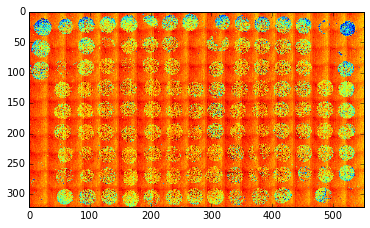

In [16]:
!if [ ! -e stitched--U00--V00--C00--Z00.png ]; then wget -q https://github.com/arve0/master/raw/master/stitched--U00--V00--C00--Z00.png; fi
img = imread('stitched--U00--V00--C00--Z00.png')
img = (img*255).astype(np.uint8) # image read as float32, image is 8 bit grayscale
imshow(img[::16, ::16])
mp = str(img.shape[0] * img.shape[1] * 1e-6 // 1)
'%s Mega pixels, shape %s, dtype %s' % (mp, img.shape, img.dtype)

## Mean filter
Calculates the mean intensity for every pixel in the image. Here I use a fixed neighborhood of 21x21 pixels for simplicity, but normally neighbors will be weighted by values of a structuring element. E.g. a disk is a common structuring element, to let pixels in equal distance from the center pixel count.

This O(2n) implementation is originally from scipy. Ref: http://www.phi-node.com/2013/06/faster-morphological-image-filters-in.html

In [3]:
def mean(img):
    """Simple mean filter.
    
    Parameters
    ----------
    img : 2d array

    Returns
    -------
    2d array
        Filtered image.
    """
    # make sure the datatype do not wrap when we calculate 
    # the sum of the neighbor pixels
    img = img.astype(np.uint16)
    # create out array in python, to allow numba to release the GIL
    out = np.empty(img.shape, dtype=np.uint8)
    # pad the image, so pixels at the edge have neighbors too
    pad = 10
    selem_size = 2*pad+1
    img = np.pad(img, pad, mode='edge')
    # intermediate array that allows for the O(2n) implementation
    rows = np.zeros(img.shape, dtype=np.uint16)
    # do the calculation in a compiled function that releases the GIL
    _mean(img, selem_size, rows, out)
    return out


@jit(nopython=True, nogil=True)
def _mean(img, selem_size, rows, out):
    iy, ix = img.shape
    pad = selem_size//2
    for i in range(iy-2*pad):
        for j in range(ix):
            for ii in range(selem_size):
                rows[i, j] += img[i+ii, j]
    # 2n instead of 2^2
    for i in range(iy-2*pad):
        for j in range(ix-2*pad):
            o = 0
            for jj in range(selem_size):
                o += rows[i, j+jj]
            out[i, j] = o / selem_size**2

## Initial speed
Lets try the filter directly on the image.

CPU times: user 4.39 s, sys: 489 ms, total: 4.88 s
Wall time: 5.14 s


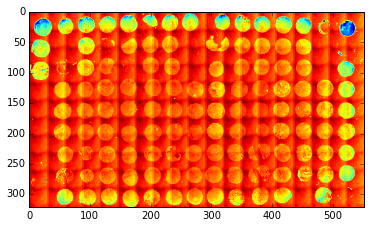

In [4]:
# use the filter, so that compile time is not included when timing below
_ = mean(img[:10, :10])
# filter directly
%time mean_nb = mean(img)
imshow(mean_nb[::16, ::16]);

## With dask
First, we'll create the dask array with one chunk only (`chunk=img.shape`).

In [5]:
img_da = da.from_array(img, chunks=img.shape)

`depth` defines the overlap. We have one chunk only, so overlap is not necessary.

`compute` must be called to start the computation.

CPU times: user 4.38 s, sys: 249 ms, total: 4.63 s
Wall time: 4.69 s


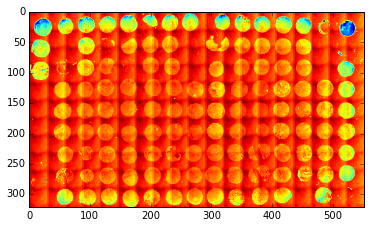

In [6]:
%time mean_da = img_da.map_overlap(mean, depth=0).compute()
imshow(mean_da[::16, ::16]);

As we can see, the performance is the same as applying the filter directly.

Now, lets chop up the image in chunks so that we can leverage all the cores in our computer.

In [7]:
from multiprocessing import cpu_count
cpu_count()

4

We have four cores, so lets split the array in four chunks.

In [8]:
img.shape

(5122, 8810)

Pixels in both axes are even, so we can split the array in equally sized chunks. If we had odd shapes, chunks would not be the same size (given four cpu cores). E.g. 101x101 image => 50x50 and 51x51 chunks.

In [9]:
chunk_size = [x//2 for x in img.shape]
img_da = da.rechunk(img_da, chunks=chunk_size)

Now, lets see if the filtering is faster.

CPU times: user 6.57 s, sys: 840 ms, total: 7.41 s
Wall time: 2.44 s


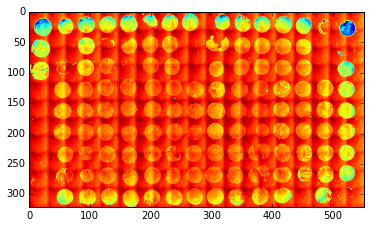

In [10]:
%time mean_da = img_da.map_overlap(mean, depth=0).compute()
imshow(mean_da[::16, ::16]);

It is :-)

If one opens the process manager, one will see that the python process is eating almost all of the CPU power (400%).

As we are looking at neighbor pixels, you might wonder what happens in the seams between chunks? Lets examine that.

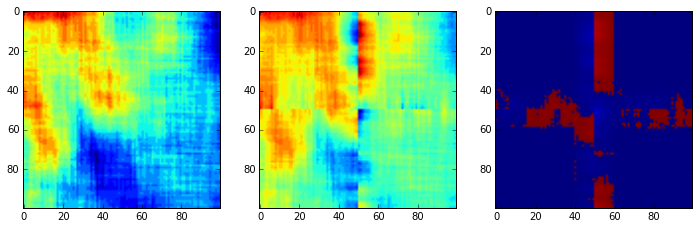

In [11]:
size = 50
mask = np.index_exp[chunk_size[0]-size:chunk_size[0]+size, chunk_size[1]-size:chunk_size[1]+size]

figure(figsize=(12,4))
subplot(131)
imshow(mean_nb[mask]) # filtered directly
subplot(132)
imshow(mean_da[mask]) # filtered in chunks with dask
subplot(133)
imshow(mean_nb[mask] - mean_da[mask]); # difference

To overcome this edge effect in the seams, we need to define a higher `depth` so that dask does the computation with a overlap. We need an overlap of 10 pixels (half the size of the neighborhood in `mean`).

CPU times: user 6.64 s, sys: 749 ms, total: 7.39 s
Wall time: 2.16 s


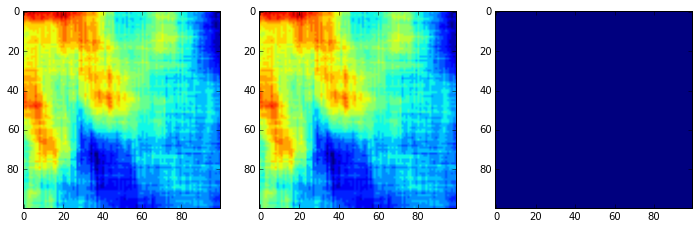

In [12]:
%time mean_da = img_da.map_overlap(mean, depth=10).compute()

figure(figsize=(12,4))
subplot(131)
imshow(mean_nb[mask]) # filtered directly
subplot(132)
imshow(mean_da[mask]) # filtered in chunks with dask
subplot(133)
imshow(mean_nb[mask] - mean_da[mask]); # difference

Edge effect is gone, nice!

Lets see if we can improve the performance. As we do not get 4x speedup, there might be that computation is not only CPU-bound. Chunksize of 1000 is a good place to start.

CPU times: user 6.91 s, sys: 423 ms, total: 7.34 s
Wall time: 2.71 s


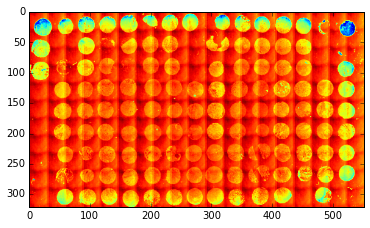

In [13]:
img_da = da.rechunk(img_da, 1000)
%time mean_da = img_da.map_overlap(mean, depth=10).compute()
imshow(mean_da[::16, ::16]);

As you see, adjusting the chunk size will affect the performance (a bit worse here). Its an good idea to identify your bottleneck and adjust the chunk size accordingly.

That's all! By chopping up the computation we utilized all cpu cores and got a speedup at best:

In [15]:
'%0.1fx' % (5.14/2.16)

'2.4x'

Happy parallel computing!